# Imports and File Reads

In [43]:
import pandas as pd
import numpy as np
# !pip install dataprep
# from dataprep.eda import create_report, plot_correlation
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_theme(style='whitegrid', palette='hsv')


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from scipy.stats import chi2_contingency, f_oneway

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE, SMOTENC


from xgboost.sklearn import XGBClassifier
# !pip3 install catboost
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [44]:
# Rename filepath prefix for your respective folder hierarchies
filepath_prefix = 'airbnb-recruiting-new-user-bookings/' # dominic
# filepath_prefix = '\\' # pawan
# filepath_prefix = '' # kim

df_airbnb_users = pd.read_csv(f'{filepath_prefix}train_users_2.csv')
df_sessions = pd.read_csv(f'{filepath_prefix}sessions.csv')
df_countries = pd.read_csv(f'{filepath_prefix}countries.csv')
df_age_bkts = pd.read_csv(f'{filepath_prefix}age_gender_bkts.csv')

# Exploratory Data Analysis

## Age Bucket Distribution
Obtained from https://www.kaggle.com/code/asmaamohy/airbnb-eda

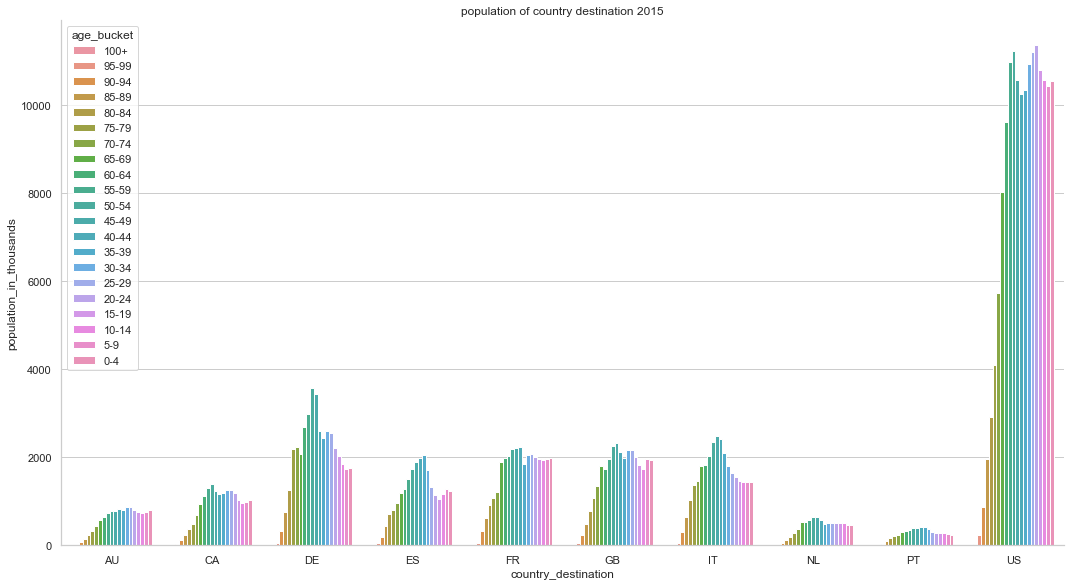

In [45]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
sns.barplot(data=df_age_bkts,x="country_destination",y="population_in_thousands",hue='age_bucket',ci=None,ax=ax)
plt.title('population of country destination 2015')
sns.despine()

## First Device vs Destination Country

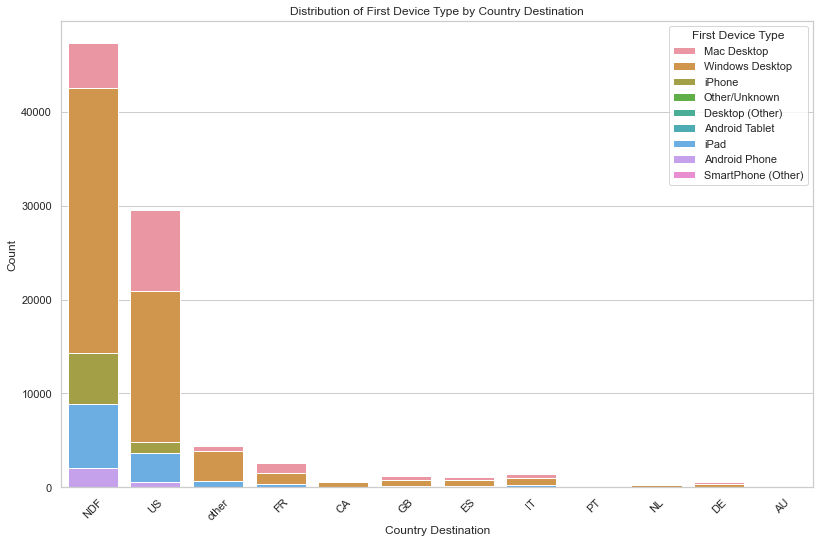

In [46]:
# Assuming df_train_users is your DataFrame
fig, ax = plt.subplots(figsize=(12, 8))

sns.countplot(data=df_airbnb_users, x='country_destination', hue='first_device_type', dodge=False, ax=ax)

ax.set_title('Distribution of First Device Type by Country Destination')
ax.set_ylabel('Count')
ax.set_xlabel('Country Destination')
plt.xticks(rotation=45)
plt.legend(title='First Device Type')

plt.show()

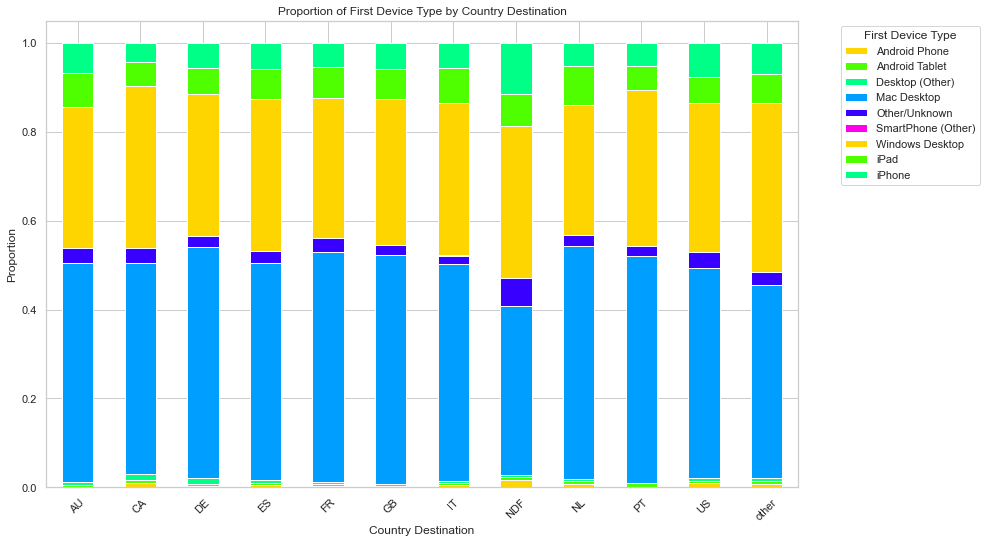

In [47]:
# Assuming df_train_users is your DataFrame
# Step 1: Calculate proportions
proportions = df_airbnb_users.groupby(['country_destination', 'first_device_type']).size().reset_index(name='count')
total_counts = df_airbnb_users['country_destination'].value_counts().reset_index()
total_counts.columns = ['country_destination', 'total_count']

proportions = proportions.merge(total_counts, on='country_destination')
proportions['proportion'] = proportions['count'] / proportions['total_count']

# Step 2: Create a pivot table
pivot_df = proportions.pivot_table(index='country_destination', columns='first_device_type', values='proportion', fill_value=0)

# Step 3: Plot the data
fig, ax = plt.subplots(figsize=(12, 8))
pivot_df.plot(kind='bar', stacked=True, ax=ax)

ax.set_title('Proportion of First Device Type by Country Destination')
ax.set_ylabel('Proportion')
ax.set_xlabel('Country Destination')
plt.xticks(rotation=45)
plt.legend(title='First Device Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

<Axes: xlabel='age'>

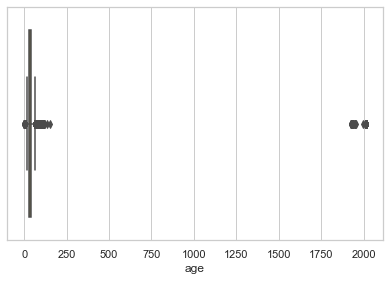

In [48]:
sns.boxplot(data=df_airbnb_users, x='age')

# Data Cleaning

In [49]:
df_airbnb_cleaned = df_airbnb_users.copy()

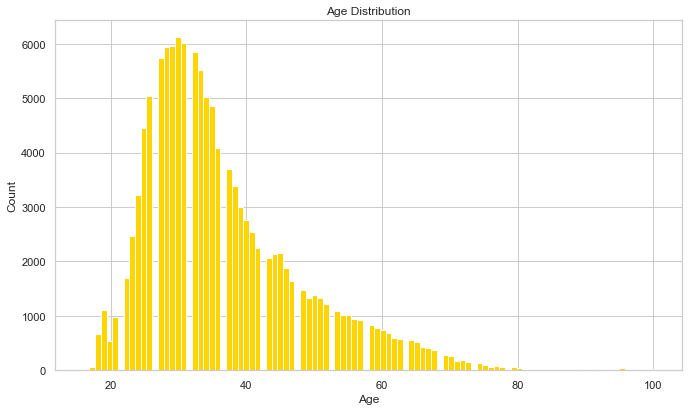

count    123079.000000
mean         36.569236
std          11.703130
min          16.000000
25%          28.000000
50%          34.000000
75%          42.000000
max         100.000000
Name: age, dtype: float64


In [50]:
# Adjust the weird ages. Seems like there are some years added to the age

ages = df_airbnb_cleaned['age'].copy()

ref_year = 2010 # "...users dataset dates back to 2010."
ages[(ages >= 1910) & (ages <= 1994)] = ref_year - ages[(ages >= 1910) & (ages <= 1994)]
ages[(ages < 16) | (ages > 100)] = np.nan

plt.figure(figsize=(10,6))
ages.hist(bins=100)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

print(ages.describe())

# replacing orginal age column with cleaned age column
df_airbnb_cleaned['age'] = ages

# Drop Ages < 18, it is AirBnB policy that minimum age of users should be 18

df_airbnb_cleaned = df_airbnb_cleaned[df_airbnb_cleaned['age'] >= 18]

In [51]:
df_airbnb_cleaned.isna().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         55781
gender                         0
age                            0
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked     1960
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
dtype: int64

In [52]:
# Drop NA
df_airbnb_cleaned['first_affiliate_tracked'] = df_airbnb_cleaned['first_affiliate_tracked'].fillna('Unknown')
df_airbnb_cleaned = df_airbnb_users.dropna()
df_airbnb_cleaned.isna().sum()

id                         0
date_account_created       0
timestamp_first_active     0
date_first_booking         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dtype: int64

In [53]:
# Calculate the total session time per user ID
total_session_time_per_user = (df_sessions.groupby('user_id')['secs_elapsed'].sum().reset_index())

# Merge the total session time with the df_train using the correct column names
df_airbnb_cleaned = pd.merge(df_airbnb_cleaned, total_session_time_per_user, left_on='id', right_on='user_id', how='left')

# Rename the column to be more descriptive
df_airbnb_cleaned.rename(columns={'secs_elapsed': 'total_session_time'}, inplace=True)

# Drop the redundant 'user_id' column
df_airbnb_cleaned.drop('user_id', axis=1, inplace=True)

# Data Processing and Feature Adjustments

In [54]:
df_airbnb_cleaned.fillna(value={'total_session_time':0}, inplace=True)

In [55]:
def get_month_diff (date, today):
    date = pd.to_datetime(date)
    return (relativedelta(date, today).years * 12 + relativedelta(date, today).months) * -1

today = datetime.today()
df_airbnb_cleaned['account_age_months'] = df_airbnb_cleaned['date_account_created'].apply(lambda date: get_month_diff(date, today))
df_airbnb_cleaned['first_booking_months'] = df_airbnb_cleaned['date_first_booking'].apply(lambda date: get_month_diff(date, today))

df_airbnb_cleaned.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,total_session_time,account_age_months,first_booking_months
0,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,0.0,164,166
1,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,0.0,150,141
2,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,0.0,165,172
3,lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,0.0,173,173
4,0d01nltbrs,2010-01-03,20100103191905,2010-01-13,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US,0.0,173,173


# Feature Importance and Correlation

In [56]:
#Extract numerical and categorical columns

categorical_features = df_airbnb_cleaned.select_dtypes(include=['object','category']).columns
numeric_features = df_airbnb_cleaned.select_dtypes(include=['int64', 'float64']).columns
categorical_indices = [df_airbnb_cleaned.columns.get_loc(col) for col in categorical_features]

In [57]:
# Perform ANOVA test to find associal between numerical features and country_destination

destinations = df_airbnb_cleaned['country_destination'].unique()

for numerical_feature in numeric_features:
    arrays = [df_airbnb_cleaned[df_airbnb_cleaned['country_destination'] == country][numerical_feature] for country in destinations]
    f_stat, p_value = f_oneway(*arrays)
    print(f'ANOVA F-statistic for feature {numerical_feature}: {f_stat}, p-value: {p_value}')

ANOVA F-statistic for feature timestamp_first_active: 20.08651427801075, p-value: 1.2206801464135887e-37
ANOVA F-statistic for feature age: 0.48992801559333016, p-value: 0.8977965530601025
ANOVA F-statistic for feature signup_flow: 12.086432562141015, p-value: 3.54008214760169e-21
ANOVA F-statistic for feature total_session_time: 3.772739547060228, p-value: 4.246919673867252e-05
ANOVA F-statistic for feature account_age_months: 26.365241275455098, p-value: 9.237252733760933e-51
ANOVA F-statistic for feature first_booking_months: 31.25707692177085, p-value: 4.7874292491202205e-61


Cramers_V Interpretation Scale
* 0.00 to 0.10: Negligible association
* 0.10 to 0.20: Weak association
* 0.20 to 0.40: Moderate association
* 0.40 to 0.60: Relatively strong association
* 0.60 to 0.80: Strong association
* 0.80 to 1.00: Very strong association

In [58]:
# Explore how the activity is correlated with all the other variables

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

for categorical_feature in categorical_features:
    cramers_v_result = cramers_v(df_airbnb_cleaned['country_destination'], df_airbnb_cleaned[categorical_feature])
    print(f"Cramers_V output for feature {categorical_feature} = {cramers_v_result}")

C:\Users\HomeBase\AppData\Local\Temp\ipykernel_1540\1938785809.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


Cramers_V output for feature id = inf
Cramers_V output for feature date_account_created = 0.04163208387799076
Cramers_V output for feature date_first_booking = 0.053403217413453045
Cramers_V output for feature gender = 0.03226014432807613
Cramers_V output for feature signup_method = 0.012151460393875553
Cramers_V output for feature language = 0.021124698432408825
Cramers_V output for feature affiliate_channel = 0.029262149791984726
Cramers_V output for feature affiliate_provider = 0.020463733939257458
Cramers_V output for feature first_affiliate_tracked = 0.015832562305249983
Cramers_V output for feature signup_app = 0.030688821460577383
Cramers_V output for feature first_device_type = 0.02214870711934843
Cramers_V output for feature first_browser = 0.007699147095242534
Cramers_V output for feature country_destination = 1.0


In [59]:
# Drop ID, Date_Account_Created, Date_First_Booking
df_airbnb_cleaned = df_airbnb_cleaned.drop(columns=['id', 'date_account_created','date_first_booking', 'timestamp_first_active'])

#Extract numerical and categorical columns again

categorical_features = df_airbnb_cleaned.select_dtypes(include=['object','category']).columns
numeric_features = df_airbnb_cleaned.select_dtypes(include=['int64', 'float64']).columns
categorical_indices = [df_airbnb_cleaned.columns.get_loc(col) for col in categorical_features]

In [60]:
# Separate features and target
X = df_airbnb_cleaned.drop('country_destination', axis=1)
y = df_airbnb_cleaned['country_destination']

# Step 1: Undersample the majority class ('US')
df_us = df_airbnb_cleaned[df_airbnb_cleaned['country_destination'] == 'US']
df_other = df_airbnb_cleaned[df_airbnb_cleaned['country_destination'] != 'US']

# Undersample "US" to match the count of the second most frequent class
df_us_under = resample(df_us, replace=False, n_samples=max(df_other['country_destination'].value_counts()), random_state=42)

# Combine undersampled "US" with the minority classes
df_balanced = pd.concat([df_us_under, df_other])

# Separate features and target variable
X_balanced = df_balanced.drop('country_destination', axis=1)
y_balanced = df_balanced['country_destination']

# Step 2: Apply SMOTE-NC
smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X_balanced, y_balanced)

# Print value counts of the target variable after oversampling
print(pd.Series(y_resampled).value_counts())

country_destination
US       7557
other    7557
CA       7557
FR       7557
IT       7557
ES       7557
GB       7557
NL       7557
DE       7557
AU       7557
PT       7557
Name: count, dtype: int64


# Test-Train Split

In [61]:
# Perform train-test split on the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

#Extract numerical and categorical columns again

categorical_features = X_train.select_dtypes(include=['object','category']).columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns

In [62]:
# Select only the categorical columns from the training and testing data
X_train_categorical = X_train[categorical_features]
X_train_numerical = X_train[numeric_features]
X_test_categorical = X_test[categorical_features]
X_test_numerical = X_test[numeric_features]

# Initialize OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')

# Fit and transform the categorical features in the training data
X_train_categorical_encoded = encoder.fit_transform(X_train_categorical)

# Transform the categorical features in the testing data
X_test_categorical_encoded = encoder.transform(X_test_categorical)

# Convert sparse matrices to DataFrames
X_train_categorical_df = pd.DataFrame(X_train_categorical_encoded.toarray(), columns=encoder.get_feature_names_out(input_features=categorical_features))
X_test_categorical_df = pd.DataFrame(X_test_categorical_encoded.toarray(), columns=encoder.get_feature_names_out(input_features=categorical_features))

X_train_numerical.reset_index(drop=True, inplace=True)
X_test_numerical.reset_index(drop=True, inplace=True)

# Concatenate DataFrames along axis=1 (horizontally) with the numerical features
X_train_encoded = pd.concat([X_train_categorical_df, X_train_numerical], axis=1)
X_test_encoded = pd.concat([X_test_categorical_df, X_test_numerical], axis=1)

# Modeling

## Supervised Classifiers and Ensembles

### Random Forest

In [63]:
rf=RandomForestClassifier()

rf.fit(X_train_encoded,y_train)
target_names = ['US', 'other', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU']
y_pred_rf=rf.predict(X_test_encoded)
print(classification_report(y_test, y_pred_rf, target_names=target_names))

              precision    recall  f1-score   support

          US       0.71      0.78      0.75      1558
       other       0.63      0.66      0.65      1513
          FR       0.67      0.70      0.68      1483
          CA       0.57      0.59      0.58      1482
          GB       0.46      0.42      0.44      1506
          ES       0.59      0.57      0.58      1555
          IT       0.57      0.55      0.56      1576
          PT       0.67      0.75      0.71      1474
          NL       0.77      0.87      0.82      1475
          DE       0.25      0.21      0.23      1500
          AU       0.25      0.21      0.23      1504

    accuracy                           0.57     16626
   macro avg       0.56      0.57      0.56     16626
weighted avg       0.56      0.57      0.56     16626



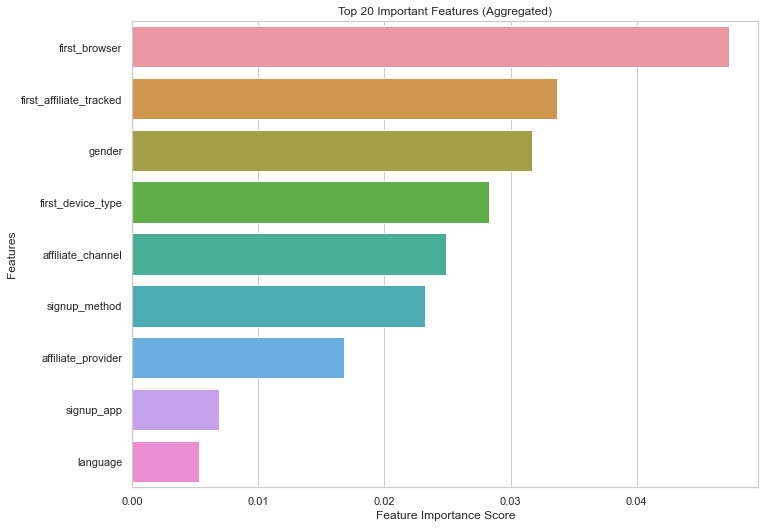

In [64]:
# Used chatGPT for this :

# Initialize an empty dictionary to store aggregated feature importances
aggregated_feature_importance = {}

feature_names=list(X_train_encoded.columns.values.tolist())
feature_imp = pd.Series(rf.feature_importances_,index=feature_names).sort_values(ascending=False)

# Loop through each original categorical feature
for feature in categorical_features:
    # Find all one-hot encoded columns corresponding to this categorical feature
    one_hot_columns = [col for col in X_train_encoded.columns if col.startswith(feature)]
    # Sum the feature importances of these one-hot encoded columns
    total_importance = feature_imp[one_hot_columns].sum()
    # Store the aggregated importance under the original feature name
    aggregated_feature_importance[feature] = total_importance

# Convert the aggregated feature importance dictionary to a pandas Series
aggregated_feature_importance_series = pd.Series(aggregated_feature_importance)

# Sort the aggregated feature importance Series
aggregated_feature_importance_series_sorted = aggregated_feature_importance_series.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=aggregated_feature_importance_series_sorted[:20], y=aggregated_feature_importance_series_sorted.index[:20])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Top 20 Important Features (Aggregated)")
plt.show()



### XGBoost

In [65]:
# Lots of ChatGPT help here. Apparently it's not easy to go from categoricals to one_hot_encoding for XGBoost directly for y (Target)
# Need to first convert to label encodings and then one hot

# Initialize LabelEncoder and OneHotEncoder
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse_output=False)

# Convert y_train and y_test to NumPy arrays
y_train_array = y_train.values
y_test_array = y_test.values

# Encode y_train with LabelEncoder
y_train_labels = label_encoder.fit_transform(y_train_array)

# Reshape y_train_labels to be 2D and apply OneHotEncoder
y_train_reshaped = y_train_labels.reshape(-1, 1)
y_train_encoded = one_hot_encoder.fit_transform(y_train_reshaped)

# Train the model
xgb = XGBClassifier()
xgb.fit(X_train_encoded, y_train_encoded)

# Predict using the model
y_pred_xgb_encoded = xgb.predict(X_test_encoded)

# Decode predictions to original label format using LabelEncoder
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_encoded.argmax(axis=1))

# Print classification report
print(classification_report(y_test_array, y_pred_xgb, target_names=target_names))

              precision    recall  f1-score   support

          US       0.11      0.98      0.20      1558
       other       0.83      0.16      0.27      1513
          FR       0.85      0.17      0.29      1483
          CA       0.78      0.08      0.14      1482
          GB       0.56      0.03      0.06      1506
          ES       0.84      0.07      0.12      1555
          IT       0.74      0.06      0.10      1576
          PT       0.86      0.24      0.38      1474
          NL       0.91      0.61      0.73      1475
          DE       0.41      0.04      0.07      1500
          AU       0.32      0.03      0.05      1504

    accuracy                           0.23     16626
   macro avg       0.66      0.22      0.22     16626
weighted avg       0.66      0.23      0.22     16626



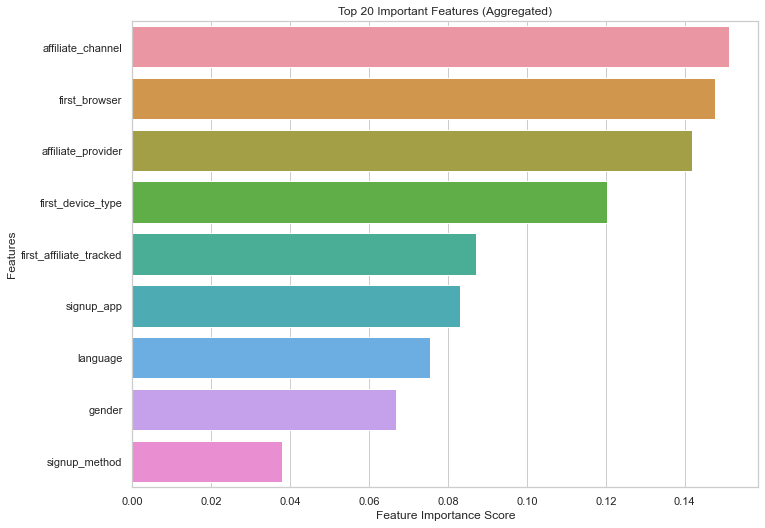

In [66]:
# Used chatGPT for this :

# Initialize an empty dictionary to store aggregated feature importances
aggregated_feature_importance = {}

feature_names=list(X_train_encoded.columns.values.tolist())
feature_imp = pd.Series(xgb.feature_importances_,index=feature_names).sort_values(ascending=False)

# Loop through each original categorical feature
for feature in categorical_features:
    # Find all one-hot encoded columns corresponding to this categorical feature
    one_hot_columns = [col for col in X_train_encoded.columns if col.startswith(feature)]
    # Sum the feature importances of these one-hot encoded columns
    total_importance = feature_imp[one_hot_columns].sum()
    # Store the aggregated importance under the original feature name
    aggregated_feature_importance[feature] = total_importance

# Convert the aggregated feature importance dictionary to a pandas Series
aggregated_feature_importance_series = pd.Series(aggregated_feature_importance)

# Sort the aggregated feature importance Series
aggregated_feature_importance_series_sorted = aggregated_feature_importance_series.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=aggregated_feature_importance_series_sorted[:20], y=aggregated_feature_importance_series_sorted.index[:20])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Top 20 Important Features (Aggregated)")
plt.show()



### CatBoost

In [67]:
catboost = CatBoostClassifier()
catboost.fit(X_train_encoded, y_train)

y_pred_catboost = catboost.predict(X_test_encoded)

print(classification_report(y_test, y_pred_catboost))

Learning rate set to 0.098014
0:	learn: 2.3845931	total: 185ms	remaining: 3m 4s
1:	learn: 2.3734713	total: 241ms	remaining: 2m
2:	learn: 2.3639154	total: 297ms	remaining: 1m 38s
3:	learn: 2.3562110	total: 354ms	remaining: 1m 28s
4:	learn: 2.3497396	total: 411ms	remaining: 1m 21s
5:	learn: 2.3440825	total: 467ms	remaining: 1m 17s
6:	learn: 2.3391811	total: 526ms	remaining: 1m 14s
7:	learn: 2.3341413	total: 582ms	remaining: 1m 12s
8:	learn: 2.3296873	total: 639ms	remaining: 1m 10s
9:	learn: 2.3211190	total: 699ms	remaining: 1m 9s
10:	learn: 2.3159764	total: 760ms	remaining: 1m 8s
11:	learn: 2.3090696	total: 814ms	remaining: 1m 7s
12:	learn: 2.3055513	total: 868ms	remaining: 1m 5s
13:	learn: 2.3014104	total: 925ms	remaining: 1m 5s
14:	learn: 2.2981121	total: 981ms	remaining: 1m 4s
15:	learn: 2.2913368	total: 1.04s	remaining: 1m 3s
16:	learn: 2.2878219	total: 1.09s	remaining: 1m 3s
17:	learn: 2.2827635	total: 1.15s	remaining: 1m 2s
18:	learn: 2.2770906	total: 1.21s	remaining: 1m 2s
19:	lea

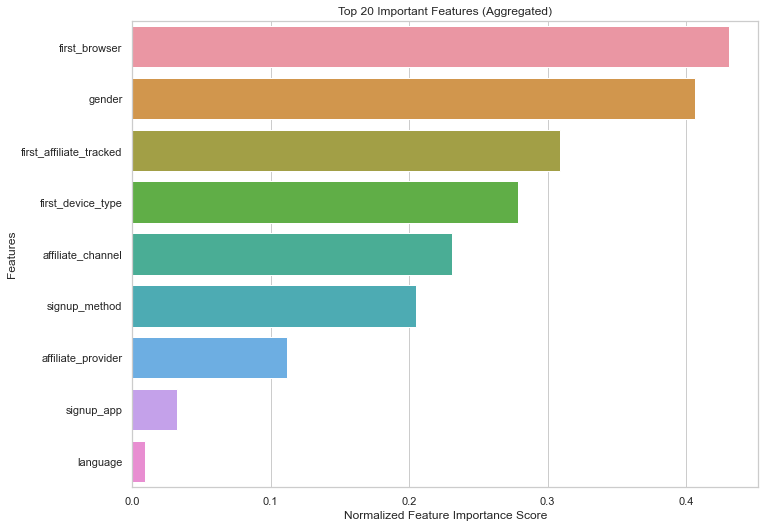

In [68]:
# Extract feature importances
feature_imp = pd.Series(catboost.get_feature_importance(), index=X_train_encoded.columns).sort_values(ascending=False)

# Normalize the feature importances to be between 0 and 1
normalized_feature_imp = feature_imp / feature_imp.max()

# Initialize an empty dictionary to store aggregated feature importances
aggregated_feature_importance = {}

# Loop through each original categorical feature
for feature in categorical_features:
    # Find all one-hot encoded columns corresponding to this categorical feature
    one_hot_columns = [col for col in X_train_encoded.columns if col.startswith(feature)]
    # Sum the feature importances of these one-hot encoded columns
    total_importance = normalized_feature_imp[one_hot_columns].sum()
    # Store the aggregated importance under the original feature name
    aggregated_feature_importance[feature] = total_importance

# Convert the aggregated feature importance dictionary to a pandas Series
aggregated_feature_importance_series = pd.Series(aggregated_feature_importance)

# Sort the aggregated feature importance Series
aggregated_feature_importance_series_sorted = aggregated_feature_importance_series.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=aggregated_feature_importance_series_sorted[:20], y=aggregated_feature_importance_series_sorted.index[:20])
plt.xlabel('Normalized Feature Importance Score')
plt.ylabel('Features')
plt.title("Top 20 Important Features (Aggregated)")
plt.show()


### Voting Ensemble

In [69]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the target variable
y_train_encoded = label_encoder.fit_transform(y_train_array)

# Create the ensemble model
ensemble_model = VotingClassifier(estimators=[('rf', rf), ('xg', xgb), ('cb', catboost)], voting='soft')

# Fit the ensemble model using the encoded target labels
ensemble_model.fit(X_train_encoded, y_train_encoded)

# Make predictions
y_pred_encoded = ensemble_model.predict(X_test_encoded)

# Decode predictions to original label format using LabelEncoder
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print(classification_report(y_test_array, y_pred, target_names=target_names))

Learning rate set to 0.098014
0:	learn: 2.3845931	total: 60.2ms	remaining: 1m
1:	learn: 2.3734713	total: 116ms	remaining: 58s
2:	learn: 2.3639154	total: 173ms	remaining: 57.4s
3:	learn: 2.3562110	total: 234ms	remaining: 58.2s
4:	learn: 2.3497396	total: 288ms	remaining: 57.2s
5:	learn: 2.3440825	total: 343ms	remaining: 56.9s
6:	learn: 2.3391811	total: 400ms	remaining: 56.7s
7:	learn: 2.3341413	total: 457ms	remaining: 56.7s
8:	learn: 2.3296873	total: 514ms	remaining: 56.5s
9:	learn: 2.3211190	total: 571ms	remaining: 56.6s
10:	learn: 2.3159764	total: 627ms	remaining: 56.4s
11:	learn: 2.3090696	total: 682ms	remaining: 56.2s
12:	learn: 2.3055513	total: 739ms	remaining: 56.1s
13:	learn: 2.3014104	total: 797ms	remaining: 56.1s
14:	learn: 2.2981121	total: 853ms	remaining: 56s
15:	learn: 2.2913368	total: 909ms	remaining: 55.9s
16:	learn: 2.2878219	total: 965ms	remaining: 55.8s
17:	learn: 2.2827635	total: 1.03s	remaining: 56s
18:	learn: 2.2770906	total: 1.08s	remaining: 56s
19:	learn: 2.2749783	

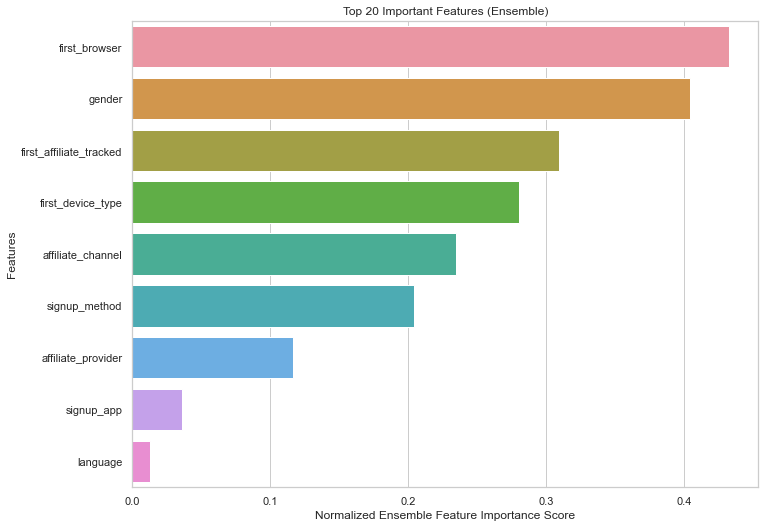

In [70]:

# Extract feature importances for each model in the ensemble
rf_feature_imp = pd.Series(rf.feature_importances_, index=X_train_encoded.columns)
xgb_feature_imp = pd.Series(xgb.feature_importances_, index=X_train_encoded.columns)
cb_feature_imp = pd.Series(catboost.get_feature_importance(), index=X_train_encoded.columns)

# Calculate the average feature importance across all models
ensemble_feature_imp = (rf_feature_imp + xgb_feature_imp + cb_feature_imp) / 3

# Normalize the feature importances to be between 0 and 1
normalized_ensemble_feature_imp = ensemble_feature_imp / ensemble_feature_imp.max()

# Initialize an empty dictionary to store aggregated feature importances
aggregated_ensemble_feature_importance = {}

# Loop through each original categorical feature
for feature in categorical_features:
    # Find all one-hot encoded columns corresponding to this categorical feature
    one_hot_columns = [col for col in X_train_encoded.columns if col.startswith(feature)]
    # Sum the feature importances of these one-hot encoded columns
    total_importance = normalized_ensemble_feature_imp[one_hot_columns].sum()
    # Store the aggregated importance under the original feature name
    aggregated_ensemble_feature_importance[feature] = total_importance

# Convert the aggregated feature importance dictionary to a pandas Series
aggregated_ensemble_feature_imp_series = pd.Series(aggregated_ensemble_feature_importance)

# Sort the aggregated feature importance Series
aggregated_ensemble_feature_imp_series_sorted = aggregated_ensemble_feature_imp_series.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=aggregated_ensemble_feature_imp_series_sorted[:20], y=aggregated_ensemble_feature_imp_series_sorted.index[:20])
plt.xlabel('Normalized Ensemble Feature Importance Score')
plt.ylabel('Features')
plt.title("Top 20 Important Features (Ensemble)")
plt.show()


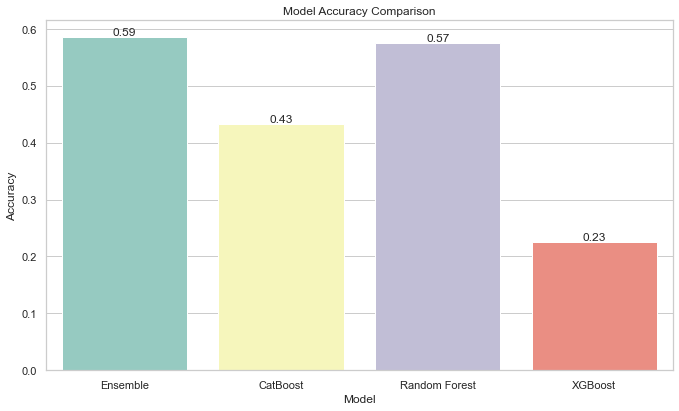

In [71]:
# List of model names
model_names = ['Ensemble', 'CatBoost', 'Random Forest', 'XGBoost']
accuracy_scores = [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_catboost), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_xgb)]

# Create a bar chart showing accuracy score comparisons
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracy_scores, palette='Set3')

# Add accuracy scores above each bar
for i in range(len(model_names)):
  plt.text(i, accuracy_scores[i], f'{accuracy_scores[i]:.2f}', ha='center', va='bottom')

plt.title('Accuracy Score Comparison')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

plt.show()


## K-Means

In [116]:
df_kmeans_train = X_train.copy()

In [117]:
# Scale the numerical columns data for k-means clustering
numeric_features = df_kmeans_train.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()

# Apply StandardScaler to numerical columns
df_kmeans_train[numeric_features] = scaler.fit_transform(df_kmeans_train[numeric_features])

# One Hot Encode
categorical_features = df_kmeans_train.select_dtypes(include='object').columns

df_kmeans_encoded = pd.get_dummies(df_kmeans_train, columns=categorical_features, drop_first=True)
display(df_kmeans_encoded.info())

display(df_kmeans_encoded.dtypes)

# Use PCA to reduce dimensionality
pca = PCA(0.95)
df_kmeans_pca = pca.fit_transform(df_kmeans_encoded)

# Just naming cleanliness ;)
df_kmeans_train = df_kmeans_pca

<class 'pandas.core.frame.DataFrame'>
Index: 66501 entries, 11343 to 15795
Data columns (total 96 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   age                                     66501 non-null  float64
 1   signup_flow                             66501 non-null  float64
 2   total_session_time                      66501 non-null  float64
 3   account_age_months                      66501 non-null  float64
 4   first_booking_months                    66501 non-null  float64
 5   gender_FEMALE                           66501 non-null  bool   
 6   gender_MALE                             66501 non-null  bool   
 7   gender_OTHER                            66501 non-null  bool   
 8   signup_method_facebook                  66501 non-null  bool   
 9   signup_method_google                    66501 non-null  bool   
 10  language_da                             66501 non-null  boo

None

age                               float64
signup_flow                       float64
total_session_time                float64
account_age_months                float64
first_booking_months              float64
                                   ...   
first_browser_Sogou Explorer         bool
first_browser_Stainless              bool
first_browser_TenFourFox             bool
first_browser_TheWorld Browser       bool
first_browser_Yandex.Browser         bool
Length: 96, dtype: object

In [81]:
def kmeans_execution(df, num_clusters):
    # Create models & store labels for different number of clusters
    model = KMeans(n_clusters = num_clusters, n_init='auto', random_state = 0) # Create KMeans object
    model.fit(df) # Apply to the data
    labels = model.labels_ # Capture K-Means labels
    distortion = model.inertia_ # Used for elbow method
    silhouette = silhouette_score(df, labels)
    centers = model.cluster_centers_
    return {
        'model' : model,
        'centers' : centers,
        'labels' : labels,
        'distortion' : distortion,
        'silhouette_score' : silhouette
    }

k_means_cluster_results = {}
num_clusters_range = range(2, 15)

for cluster in num_clusters_range:
    k_means_cluster_results[cluster] = kmeans_execution(df_kmeans_train, cluster)
    print(f"Silhouette score for {cluster} clusters = {k_means_cluster_results[cluster]['silhouette_score']}")

Silhouette score for 2 clusters = 0.1911128619347754
Silhouette score for 3 clusters = 0.18188078725784887
Silhouette score for 4 clusters = 0.22860446717497301
Silhouette score for 5 clusters = 0.23847234848279303
Silhouette score for 6 clusters = 0.1591376310070957
Silhouette score for 7 clusters = 0.17967893460356882
Silhouette score for 8 clusters = 0.17839586562843585
Silhouette score for 9 clusters = 0.18257834853204172
Silhouette score for 10 clusters = 0.17734214527445735
Silhouette score for 11 clusters = 0.1767460134423984
Silhouette score for 12 clusters = 0.17861027312585215
Silhouette score for 13 clusters = 0.17994402861075542
Silhouette score for 14 clusters = 0.17695207101164195
Silhouette score for 15 clusters = 0.17494157196955248
Silhouette score for 16 clusters = 0.176736388641388


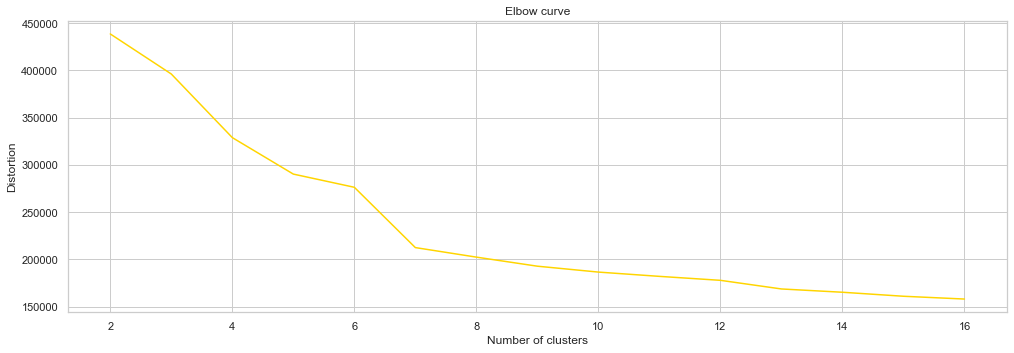

In [82]:
# Extracting distortions for different k values
distortions = [k_means_cluster_results[cluster]['distortion'] for cluster in num_clusters_range]

fig = plt.figure(figsize=(15, 5))
plt.plot(num_clusters_range, distortions)
plt.grid(True)
plt.title('Elbow curve')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

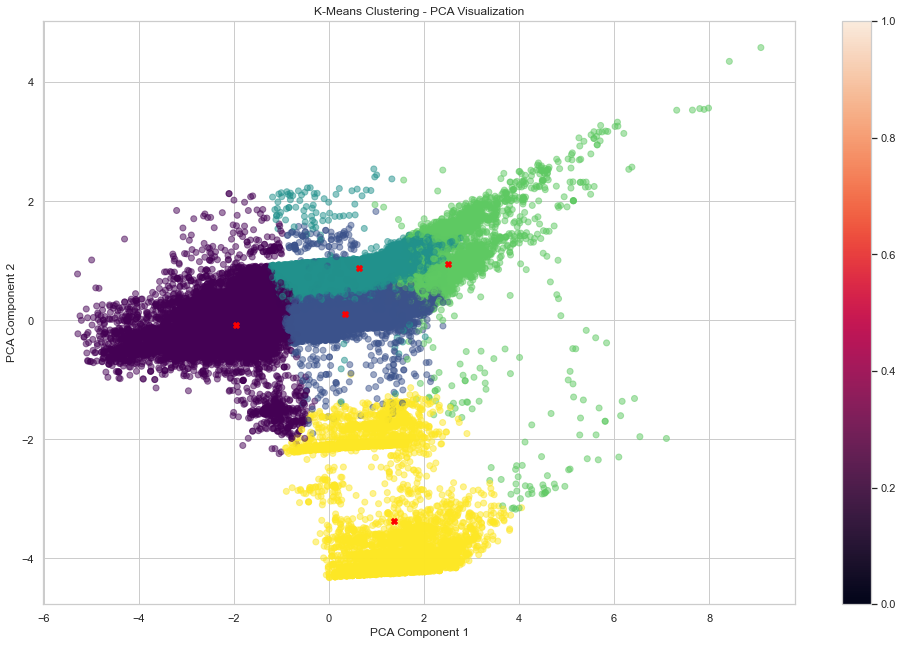

In [95]:
# Visualize clusters in PCA space
ideal_cluster_size = 5

plt.figure(figsize=(15, 10))
plt.scatter(df_kmeans_train[:, 0], df_kmeans_train[:, 1], c=k_means_cluster_results[ideal_cluster_size]['labels'], cmap='viridis', alpha=0.5, label='Data points')
plt.scatter(k_means_cluster_results[ideal_cluster_size]['centers'][:,0], k_means_cluster_results[ideal_cluster_size]['centers'][:,1], c='red', marker='X', label='Cluster Centers')
plt.title('K-Means Clustering - PCA Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

### KMeans Analysis

PCA removes column names so we unfortunately lose the ability to analyze the features by name. However, we see that from our 96 columns, 95% percent of relevance was maintained within 13 features.
Optionally, we can run the KMeans without PCA, so that we can analyze the clusters that way, and maybe reduce it down to only the most relevant features afterwards.

Cluster Sizes:
   Count  Percentage
0  17362       26.11
1  27202       40.90
2  13113       19.72
3   3890        5.85
4   4934        7.42


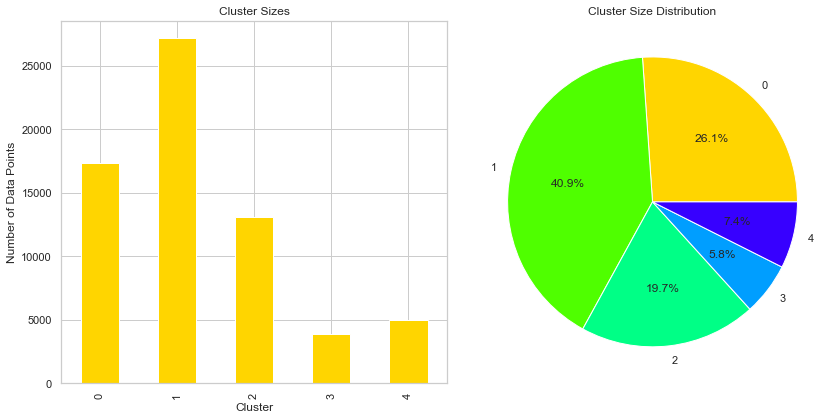

In [127]:
def analyze_cluster_sizes(kmeans_results, n_clusters):
    labels = kmeans_results[n_clusters]['labels']
    
    cluster_sizes = pd.Series(labels).value_counts().sort_index()
    
    total_points = len(labels)
    cluster_percentages = (cluster_sizes / total_points * 100).round(2)
    
    cluster_info = pd.DataFrame({
        'Count': cluster_sizes,
        'Percentage': cluster_percentages
    })
    
    print("Cluster Sizes:")
    print(cluster_info)
    
    plt.figure(figsize=(12, 6))
    # bar chart
    plt.subplot(1, 2, 1)
    cluster_sizes.plot(kind='bar')
    plt.title('Cluster Sizes')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Data Points')
    # pie chart
    plt.subplot(1, 2, 2)
    plt.pie(cluster_sizes, labels=cluster_sizes.index, autopct='%1.1f%%')
    plt.title('Cluster Size Distribution')
    plt.tight_layout()
    plt.show()

analyze_cluster_sizes(k_means_cluster_results, ideal_cluster_size)

   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0   1.598362   0.691084   0.719986   0.728626   1.464194   1.533337   
1   1.939558   0.392681   0.456046   0.661560   0.605827   2.004627   
2   1.888159   0.380105   0.517794   0.733254   0.708386   1.745353   
3   1.173006   1.053420   0.273023   2.468616   1.966272   1.443028   
4   1.934126   2.419553   0.341588   1.094225   0.659523   0.773769   

   Feature_6  Feature_7  Feature_8  Feature_9  Feature_10  Feature_11  \
0   1.563678   1.154171   1.109288   1.024305    0.840338    0.542658   
1   1.819066   1.447985   1.277736   1.117164    1.049263    0.654058   
2   1.553775   1.160040   1.033444   0.860375    0.567067    0.640827   
3   1.224629   0.949835   0.736181   0.671794    0.654580    0.497405   
4   1.733284   0.598373   1.333450   0.262766    0.886718    0.613690   

   Feature_12  Feature_13  
0    0.497926    0.532045  
1    0.193452    0.380977  
2    1.466893    0.744529  
3    0.498421    0.389

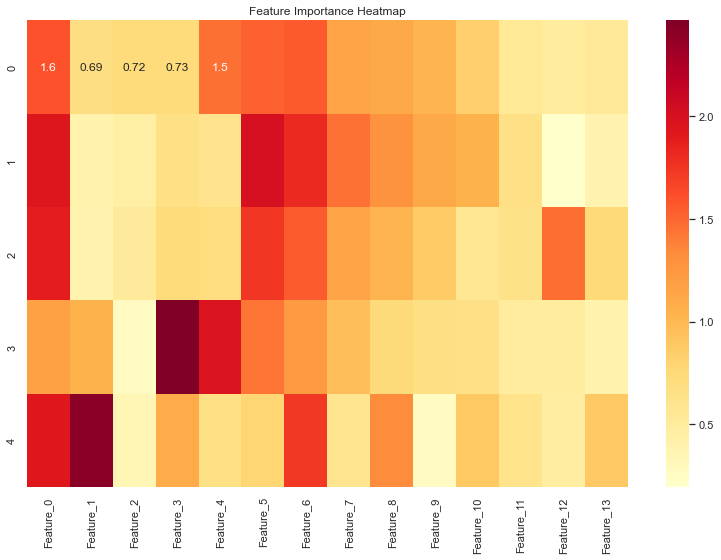

In [128]:
def get_feature_importance(df, labels, cluster_centers):
    feature_importance = []
    for i, center in enumerate(cluster_centers):
        cluster_points = df[labels == i]
        distances = np.abs(cluster_points - center)
        importance = distances.mean(axis=0) / distances.mean().sum()
        feature_importance.append(importance)
    
    column_names = [f'Feature_{i}' for i in range(X.shape[1])]
    
    return pd.DataFrame(feature_importance, columns=column_names)


feature_importance = get_feature_importance(df_kmeans_train, 
                                            k_means_cluster_results[ideal_cluster_size]['labels'],
                                            k_means_cluster_results[ideal_cluster_size]['centers'])

print(feature_importance)

plt.figure(figsize=(12, 8))
sns.heatmap(feature_importance, annot=True, cmap='YlOrRd')
plt.title('Feature Importance Heatmap')
plt.show()